In [1]:
import os
import kagglehub

# Will download the dataset to ur computer
path = kagglehub.dataset_download("nickyazdani/license-plate-text-recognition-dataset")
image_folder = os.path.join(path, "cropped_lps/cropped_lps/")

In [2]:
import torch

device = torch.device("cuda")
torch.cuda.empty_cache()
device

device(type='cuda')

In [3]:
# from transformers import YolosImageProcessor, YolosForObjectDetection
# from PIL import Image, ImageDraw, ImageOps
# from datasets import load_dataset

# yolo_processor = YolosImageProcessor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
# yolo_model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection').to(device)

In [4]:
def add_image(row):
    image = os.path.join(image_folder, row["images"])
    row["images"] = image
    return row

In [5]:
from kagglehub import KaggleDatasetAdapter
import kagglehub
import os

In [6]:
# Loads the csv folder that contains the labels for each image in
# the downloaded dataset


# Set the path to the file you'd like to load
file_path = "lpr.csv"

# Load the latest version
train = kagglehub.load_dataset(
  KaggleDatasetAdapter.HUGGING_FACE,
  "nickyazdani/license-plate-text-recognition-dataset",
  file_path,
  pandas_kwargs={'nrows': 6000}
  ).map(add_image, batched=False)

print("Hugging Face Dataset:", train)

C:\Users\lozan\AppData\Local\Temp\ipykernel_14968\2659667106.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  train = kagglehub.load_dataset(


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Hugging Face Dataset: Dataset({
    features: ['Unnamed: 0', 'images', 'labels'],
    num_rows: 6000
})


In [7]:
from torchvision import transforms
import torch.nn.functional as F
import io

def crop_objects(ds):
    '''
     Uses bounding boxes from YOLO model to 
 return list of cropped images that should
  contain the license plates
    '''

    
    image = ds["image"]
    box = ds["bbox"][0]
    
    
    normalized = all(v < 1 for v in box)  
    
    x_min, y_min, x_max, y_max = box

    if normalized:
        width, height = image.size
        x_min = int(x_min * width)
        y_min = int(y_min * height)
        x_max = int(x_max * width)
        y_max = int(y_max * height)

    # Ensure valid coordinates
    if x_min > x_max:
        x_min, x_max = x_max, x_min
    if y_min > y_max:
        y_min, y_max = y_max, y_min

    
    try:
        # Crop image
        img_cropped = image.crop([x_min, y_min, x_max, y_max])
    except:

        print(x_min, y_min, x_max, y_max, normalized)
        image.show()
        raise Exception

    ds["images"] = img_cropped
    ds["labels"] = ds["target"][0]
    ds["bbox"] = box
    del ds["image"]
    del ds['target']
    return ds

In [8]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

trocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed', use_fast=False)
trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed').to(device)


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decod

In [9]:
from torchvision.transforms import v2

augment = transforms.Compose([  # Slight rotation
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust contrast
    v2.GaussianBlur(5),  # Simulate blur
    v2.RandomResize(30,300)  # Standardize input size
])

In [10]:
from torch.utils.data import Dataset, DataLoader

class LPDataset(Dataset):
    
    def __init__(self, ds, processor):
        self.processor = processor
        self.ds = ds
        self.pad = 9

    def __len__(self):
        return len(self.ds)

    
    def __getitem__(self, index):
        row = self.ds[index]
        images = Image.open(row["images"])
        images = augment(images)
        label = row["labels"]

        pixel_values =  self.processor(images, return_tensors="pt").pixel_values.squeeze().to(device)
        labels = self.processor.tokenizer(label, return_tensors="pt").input_ids.squeeze().to(device)

        return {"pixel_values": pixel_values, "input_ids":labels}

In [11]:
from PIL import Image
p_train = LPDataset(train, trocr_processor)

In [12]:
import torch.nn.functional as F

def collate_fn(batch):
    input_ids = [i["input_ids"] for i in batch]
    pixel_values = [i["pixel_values"] for i in batch]

    max = 0
    for i in input_ids:
        if max < i.size()[0]:
            max = i.size()[0]
    processed = []

    for i in input_ids:
        processed.append(F.pad(i,(0,max-i.size()[0]), "constant", trocr_processor.tokenizer.pad_token_id))
    

    # for x,b in enumerate(batch):
    #     to_add = []
    #     for i in range(b["input_ids"].size()[0]):
    #         to_add.append(processed.pop(0))
    input_ids = torch.stack(processed)
    pixel_values = torch.stack(pixel_values)

    return {"pixel_values":pixel_values,"labels":input_ids }

In [13]:
tdl = DataLoader(p_train, batch_size=20, shuffle=True, collate_fn=collate_fn)

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
trocr_model.config.decoder_start_token_id = trocr_processor.tokenizer.cls_token_id
trocr_model.config.pad_token_id = trocr_processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
trocr_model.config.vocab_size = trocr_model.config.decoder.vocab_size

# set beam search parameters
trocr_model.config.eos_token_id = trocr_processor.tokenizer.eos_token_id
trocr_model.config.max_length = 100
trocr_model.config.early_stopping = True
trocr_model.config.no_repeat_ngram_size = 3
trocr_model.config.length_penalty = 2.0
trocr_model.config.num_beams = 4

In [15]:
from evaluate import load

cer_metric = load("cer")
def compute_cer(pred_ids, label_ids):
    pred_str = trocr_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = trocr_processor.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from torch.optim import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(trocr_model.parameters(), lr=5e-5)

for epoch in range(20):
    trocr_model.train()
    train_loss = 0.0

    for batch in tqdm(tdl):
        for k,v in batch.items():
            batch[k] = v.to(device)
        outputs = trocr_model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    
    print(f"Loss after epoch {epoch}:", train_loss/len(tdl))

In [19]:
import random
i = random.randint(8,199)


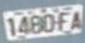

In [26]:
img = Image.open('image.png')
img

In [25]:
with torch.no_grad():
    p = trocr_processor(img, return_tensors="pt").pixel_values.to(device)
    output = trocr_model.generate(p)
    results = trocr_processor.batch_decode(output, skip_special_tokens=True)

print("Predicted Text:", results)

Predicted Text: ['G5875']


In [23]:
trocr_model.save_pretrained("model/model.pt")

c:\Users\lozan\OneDrive - East Carolina University\ECU Materials\Sophomore\Spring\Natural Language Processing\HW\Yolo\Yolo_Trocr_License_Plate_Model\venv\Lib\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 100, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
